<a href="https://colab.research.google.com/github/Joychema/TSP_Burundi/blob/main/TSP_burundi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This cell performs two essential tasks: **installing necessary Python libraries** and **importing them** for use in your script.

*geopandas:* Enables you to read your shapefiles (containing the town and country data) and manipulate them as GeoDataFrames

*matplotlib:* Allows you to create the map visualization, plotting the towns, country boundary, and the TSP route.

*networkx:* Provides the tools to create the graph representing the road network (or direct connections in this case) and solve the Traveling Salesman Problem.

*shapely:* Provides the Point object, which is essential for representing the town locations as geometric points

In [1]:
!pip install geopandas matplotlib networkx shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point

###This code cell is responsible for **loading geospatial data from shapefiles into geopandas GeoDataFrames**.

 *import geopandas as gpd:* This line imports the geopandas library and assigns it the alias gpd

 *gpd.read_file():* is the function used to read geospatial data from a file

 In essence, these lines load the spatial data necessary for subsequent analysis and mapping, making the town locations and country boundaries available for further processing within the Python script

In [13]:
import geopandas as gpd

towns_gdf = gpd.read_file("/content/drive/MyDrive/Burundi_Shapefiles/Burundi_towns")
country_gdf = gpd.read_file("/content/drive/MyDrive/Burundi_Shapefiles/Burundi_admin", layer='gadm41_BDI_1')

###Here the focus is on **creating the "geometry" column within the towns_gdf GeoDataFrame**, which is essential for geopandas to recognize and work with the spatial data. It also **sets the Coordinate Reference System (CRS) for the GeoDataFrame.**


*towns_gdf['geometry'] = towns_gdf.apply(lambda row: Point(row['X_coord'], row['Y_coord']), axis=1):*
This line creates the "geometry" column in the towns_gdf GeoDataFrame.

*towns_gdf.crs = "EPSG:4326":*
This line sets the Coordinate Reference System (CRS) of the towns_gdf GeoDataFrame.

In [14]:
import geopandas as gpd
from shapely.geometry import Point

#  towns_gdf is the GeoDataFrame
towns_gdf['geometry'] = towns_gdf.apply(lambda row: Point(row['X_coord'], row['Y_coord']), axis=1)

# Ensure the GeoDataFrame has a CRS (Coordinate Reference System)
towns_gdf.crs = "EPSG:4326"  # WGS 84 (latitude/longitude)

## This code cell **focuses on building a network graph from the town data**, solving the Traveling Salesman Problem (TSP), and creating a GeoDataFrame representing the optimal route.

***import networkx as nx:***
This line imports the networkx library, which is used for creating and manipulating graphs.

*town_names = towns_gdf["name"].tolist() and town_points = towns_gdf["geometry"].tolist():*
These lines extract the town names and their geometry (Point objects) from the towns_gdf GeoDataFrame into lists.

**Filtering None Values:**

*town_data = [(name, point) for name, point in zip(town_names, town_points) if name is not None]* :
This line uses a list comprehension to filter out any entries where name is None. It combines town_names and town_points using zip, and only includes pairs where the town name is not None.

*town_names = [data[0] for data in town_data]* :
This line extracts the town names from the filtered town_data list.

*town_points = [data[1] for data in town_data]* :
This line extracts the town point geometries from the filtered town_data list.

*town_geocodes = {town_names[i]: (point.y, point.x) for i, point in enumerate(town_points)}:*
This line creates a dictionary town_geocodes that maps each town name to its (latitude, longitude) coordinates.

**Graph Creation:**

*G = nx.Graph():*Initializes an empty undirected graph G.
The nested for loops iterate through all pairs of towns.

*dist = town_points[i].distance(town_points[j]):* Calculates the Euclidean distance between each pair of towns.

*G.add_edge(town1, town2, weight=dist):* Adds an edge between the towns with the calculated distance as the edge weight.

**TSP Solution:**

*tsp_route = nx.approximation.traveling_salesman_problem(G, nodes=town_names):* Solves the TSP using an approximation algorithm from networkx, returning the optimal route as a list of town names.

**Route GeoDataFrame Creation:**

*route_points = [Point(town_geocodes[town][1], town_geocodes[town][0]) for town in tsp_route]:* Creates a list of Point objects representing the route.

*route_gdf = gpd.GeoDataFrame(geometry=route_points, crs=towns_gdf.crs):* Creates a GeoDataFrame route_gdf from the route points, using the same CRS as the towns_gdf.

In summary, this cell builds the graph representation of the towns, solves the TSP, and prepares the output as a geodataframe that is ready for plotting.

In [15]:
import networkx as nx

town_names = towns_gdf["name"].tolist()
town_points = towns_gdf["geometry"].tolist()

# Filter out None values from both town_names and town_points simultaneously
town_data = [(name, point) for name, point in zip(town_names, town_points) if name is not None]
town_names = [data[0] for data in town_data]
town_points = [data[1] for data in town_data]

town_geocodes = {town_names[i]: (point.y, point.x) for i, point in enumerate(town_points)}
G = nx.Graph()
for i, town1 in enumerate(town_names):
    for j, town2 in enumerate(town_names):
        if i < j:
            dist = town_points[i].distance(town_points[j])
            G.add_edge(town1, town2, weight=dist)

tsp_route = nx.approximation.traveling_salesman_problem(G, nodes=town_names)

route_points = [Point(town_geocodes[town][1], town_geocodes[town][0]) for town in tsp_route]
route_gdf = gpd.GeoDataFrame(geometry=route_points, crs=towns_gdf.crs)



##This cell **takes the ordered list of town names from the TSP solution**, converts it into an **ordered list of Point geometries**, and then **creates a GeoDataFrame that represents the optimal route**, ensuring spatial consistency with the original town data.

In [16]:
route_points = [Point(town_geocodes[town][1], town_geocodes[town][0]) for town in tsp_route]
route_gdf = gpd.GeoDataFrame(geometry=route_points, crs=towns_gdf.crs)

##This final code cell is responsible for **visualizing the results of the Traveling Salesman Problem (TSP) analysis** on a map using *matplotlib*

*import matplotlib.pyplot as plt:*
This line imports the matplotlib.pyplot module and assigns it the alias plt, which is used for creating plots and visualizations.

*fig, ax = plt.subplots(figsize=(10, 10)):*
This line creates a matplotlib figure *(fig)* and an axes object *(ax)*.

*country_gdf.plot(ax=ax, color='lightgray', edgecolor='black'):*
This line plots the country boundary from the country_gdf GeoDataFrame onto the axes ax.

*towns_gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Towns'):*
This line plots the town locations from the towns_gdf GeoDataFrame onto the axes ax.

*route_gdf.plot(ax=ax, marker='x', color='blue', markersize=50, label='Route'):*
This line plots the TSP route from the route_gdf GeoDataFrame onto the axes ax.

*for i in range(len(tsp_route) - 1): ... ax.plot(...):*
This loop draws lines connecting the towns in the optimal route.

*plt.legend():*
This line adds a legend to the plot, showing the labels for the towns and the route.

*plt.title("Optimal Coca-Cola Route in Burundi"):*
This line adds a title to the plot.

*plt.savefig("burundi_route.pdf"):*
This line saves the plot as a PDF file named "burundi_route.pdf".

*plt.show():*
This line displays the plot.

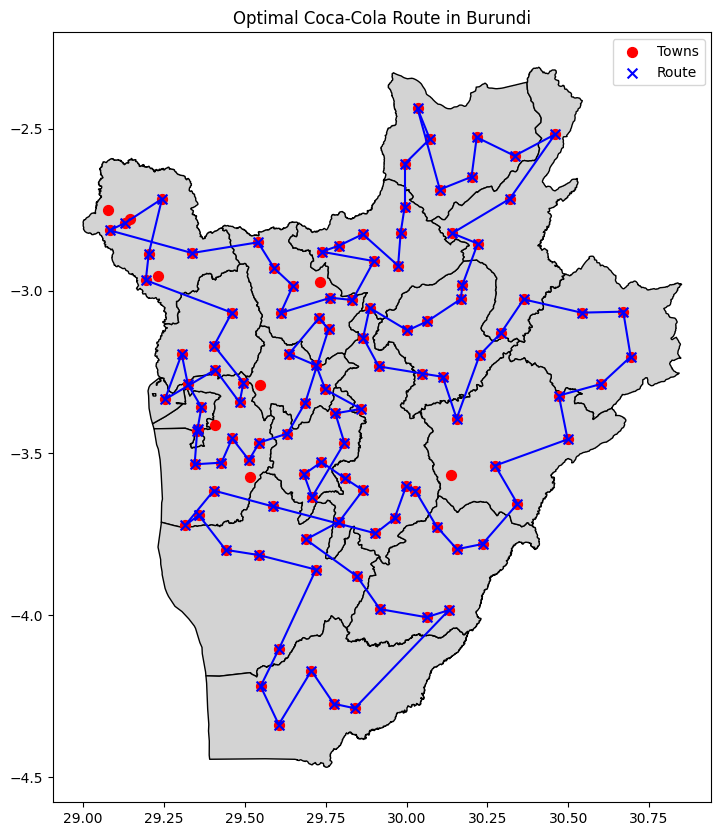

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
country_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
towns_gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Towns')
route_gdf.plot(ax=ax, marker='x', color='blue', markersize=50, label='Route')

for i in range(len(tsp_route) - 1):
    start = town_geocodes[tsp_route[i]]
    end = town_geocodes[tsp_route[i + 1]]
    ax.plot([start[1], end[1]], [start[0], end[0]], color='blue')

plt.legend()
plt.title("Optimal Coca-Cola Route in Burundi")
plt.savefig("burundi_route.pdf")
plt.show()

##Summary of Conclusion Achieved:

###This code successfully:

####**Loaded geospatial data:** It loaded the town and country boundary shapefiles.

####**Processed the data:** It created a network graph representing the towns, solved the TSP, and created a GeoDataFrame for the optimal route.

####**Visualized the results:** It generated a map showing the country boundary, the towns, and the optimal route connecting them.


### The final map visually represents the solution to the Traveling Salesman Problem, providing a clear and intuitive way to understand the optimal route for a Coca-Cola salesman to visit all the towns in Burundi.